# Оценка кредитного риска заёмщиков

**Цель**: На основе данных о клиентах банка определить, какие факторы чаще всего приводят к дефолту, и спрогнозировать риски с помощью готовых методов ML. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Разведочный анализ данных (EDA)

In [2]:
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
len(df)

32581

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [6]:
df['person_home_ownership'].value_counts()

person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64

In [7]:
df['loan_intent'].value_counts()

loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64

## Поля:  
1. `person_age` – возраст;
   
2. `person_income` – годовой доход;

3. `person_home_ownership` – тип жилья
   - RENT - аренда
   - MORTGAGE - ипотека
   - OWN - собственное жильё
   - OTHER - другие варианты;

4. `person_emp_length` – стаж работы;

5. `loan_intent` – цель кредита
   - EDUCATION - образование
   - MEDICAL - медицинские расходы
   - VENTURE - бизнес
   - PERSONAL - личные нужды
   - DEBTCONSOLIDATION - погашение долгов
   - HOMEIMPROVEMENT - ремонт жилья;
     
6. `loan_grade` – оценка кредита(A - G);
7. `loan_amnt` - сумма кредита (в долларах);

8. `loan_int_rate` - процентная ставка;
9. `loan_status` – **целевая переменная** (0 = погашен, 1 = дефолт);

10. `loan_percent_income` - отношение платежа по кредиту к доходу;

11. `cb_person_default_on_file` - Наличие дефолтов в истории(Y/N);

12. `cb_person_cred_hist_length` - длина кредитной истории (в годах)

## Поиск и обработка пропусков

In [8]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Обработаем пропуски следующим образом:
1. Для `person_emp_length` заменим **NaN** на 0
2. Для `loan_int_rate` заменим **NaN** медианным значением по всему ряду

In [9]:
df['person_emp_length'] = df['person_emp_length'].fillna(0)
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

In [10]:
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

Text(0.5, 1.0, 'Соотношение дефолтов')

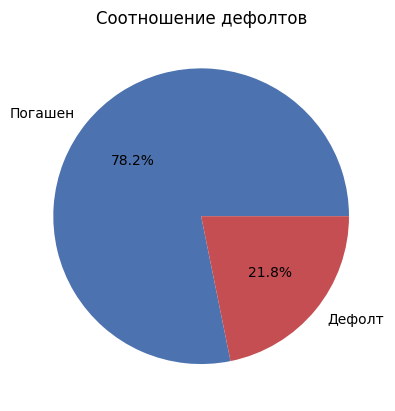

In [11]:
status_counts = df['loan_status'].value_counts()
plt.pie(status_counts, labels=['Погашен','Дефолт'], autopct='%1.1f%%', colors=['#4c72b0', '#c44e52'])
plt.title('Соотношение дефолтов')

person_age                   -0.02
person_income                -0.14
person_emp_length            -0.09
loan_amnt                     0.11
loan_int_rate                 0.32
loan_status                   1.00
loan_percent_income           0.38
cb_person_cred_hist_length   -0.02
Name: loan_status, dtype: float64


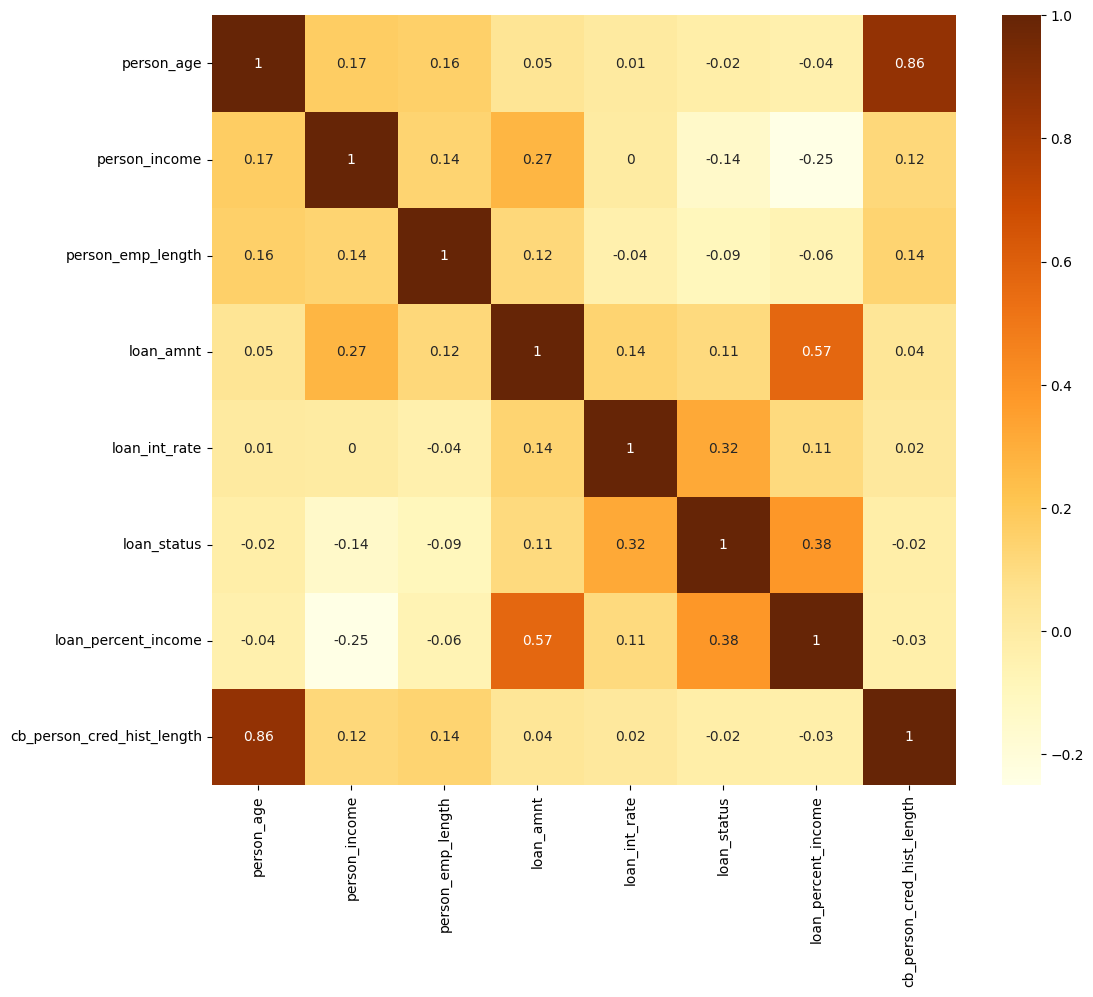

In [12]:
corr = df[df.select_dtypes(include=['number']).columns].corr().round(2)
plt.figure(figsize = (12,10))
sns.heatmap(corr, annot = True, cmap = 'YlOrBr')
print(corr['loan_status'])

# Возрастные группы

Text(0.5, 1.0, 'Распределение возраста')

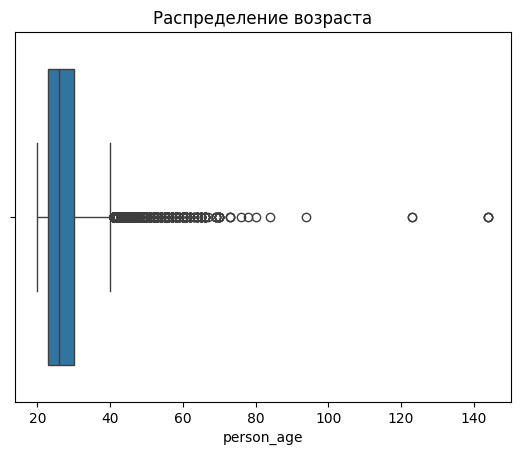

In [13]:
sns.boxplot(x=df['person_age'])
plt.title('Распределение возраста')

In [14]:
df = df[df['person_age'] <= 80]
len(df)

32574

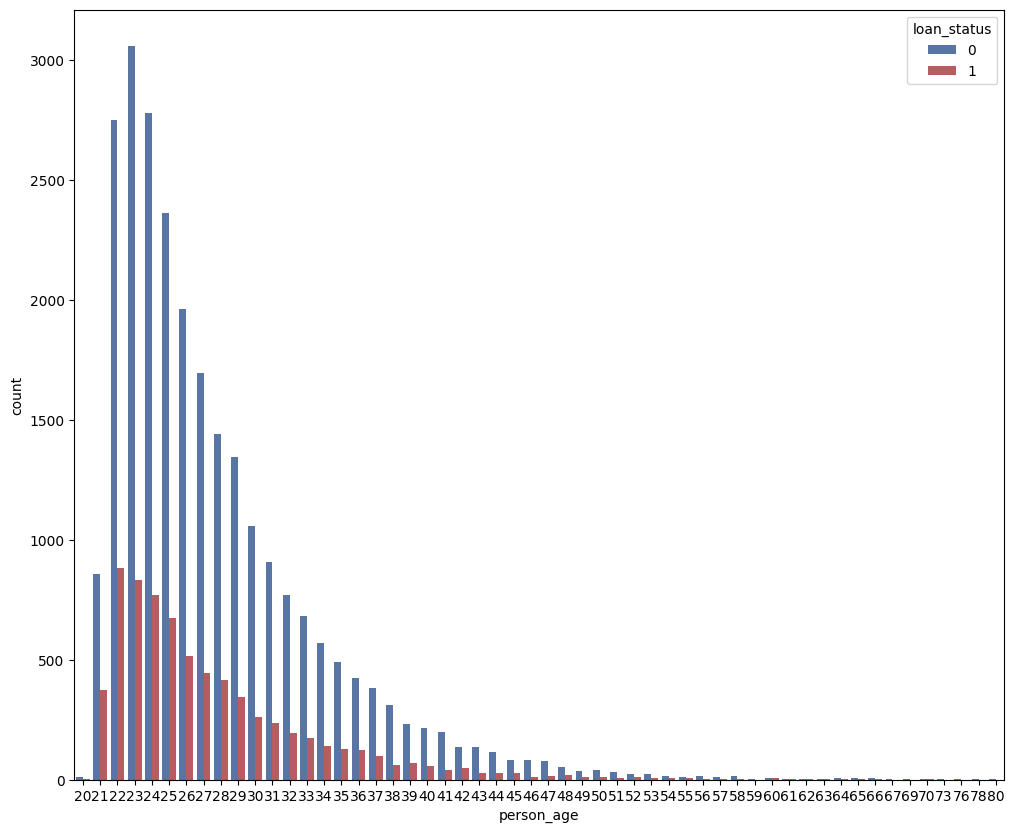

In [15]:
plt.figure(figsize=[12,10])
sns.countplot(x = 'person_age', hue= 'loan_status', data=df, palette={0: '#4c72b0', 1: '#c44e52'});

In [16]:
total_clients = len(df)
age_group = df[df['person_age'] <= 40]
percentage = len(age_group) / total_clients * 100

print(f"Доля заемщиков до 40 лет: {percentage:.1f}%")

Доля заемщиков до 40 лет: 95.4%


#### Наблюдение: `Основная масса клиентов (95.4%) сосредоточена в возрастной группе до 40 лет - это ключевая аудитория`

# Анализ целей взятия кредита

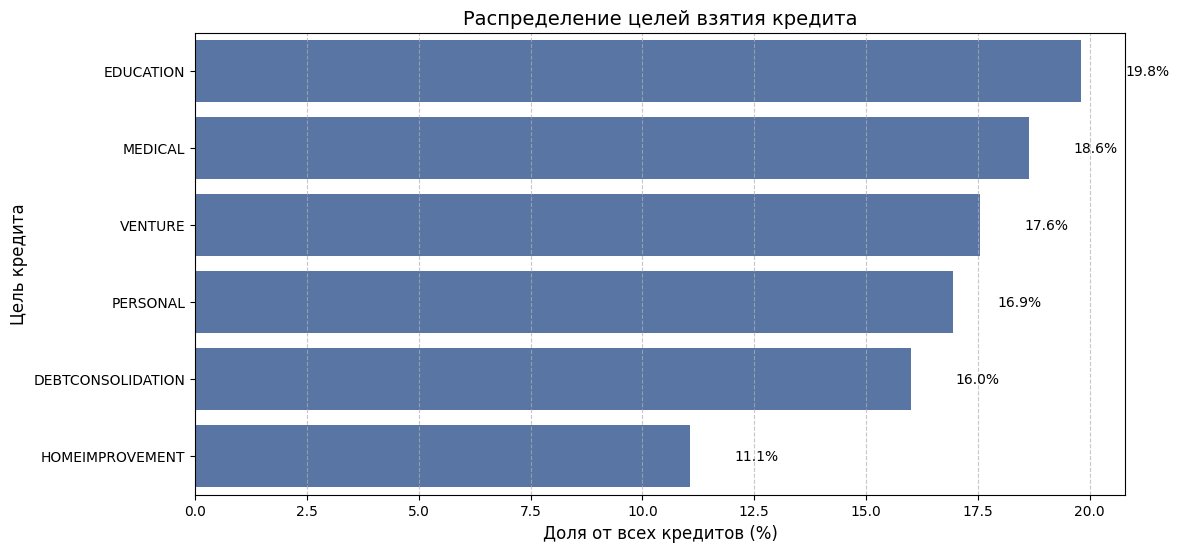

In [17]:
loan_purposes = df['loan_intent'].value_counts(normalize=True) * 100

plt.figure(figsize=(12,6))
sns.barplot(x=loan_purposes.values, y=loan_purposes.index,  color = '#4c72b0')
plt.title('Распределение целей взятия кредита', fontsize=14)
plt.xlabel('Доля от всех кредитов (%)', fontsize=12)
plt.ylabel('Цель кредита', fontsize=12)
for i, v in enumerate(loan_purposes.values):
    plt.text(v + 1, i, f'{v:.1f}%', color='black', va='center')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### `Заметим, что цели взятия кредита распределены практически равномерно по каждой из категорий`

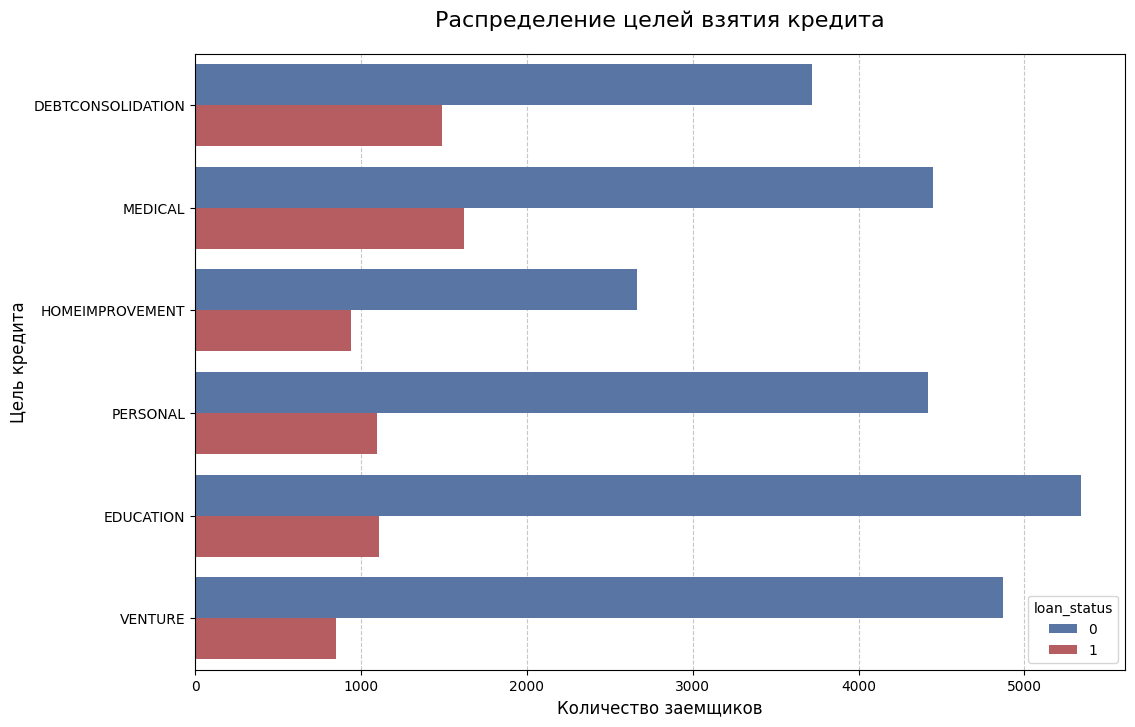

In [18]:
plt.figure(figsize=(12, 8))

ax = sns.countplot( y='loan_intent',  hue='loan_status',  data=df, palette={0: '#4c72b0', 1: '#c44e52'}, 
                    order=df.groupby('loan_intent')['loan_status'].mean().sort_values(ascending=False).index)

plt.title('Распределение целей взятия кредита', fontsize=16, pad=20)
plt.xlabel('Количество заемщиков', fontsize=12)
plt.ylabel('Цель кредита', fontsize=12)
plt.legend(title='loan_status', labels=['0', '1'],loc='lower right')

ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.show()

# Тип жилья

In [19]:
pd.crosstab(df['person_home_ownership'], df['loan_status'], normalize='index')*100

loan_status,0,1
person_home_ownership,,
MORTGAGE,87.426531,12.573469
OTHER,69.158879,30.841121
OWN,92.530960,7.469040
RENT,68.422333,31.577667


In [20]:
print(df['person_home_ownership'].value_counts())
print(len(df))

person_home_ownership
RENT        16442
MORTGAGE    13441
OWN          2584
OTHER         107
Name: count, dtype: int64
32574


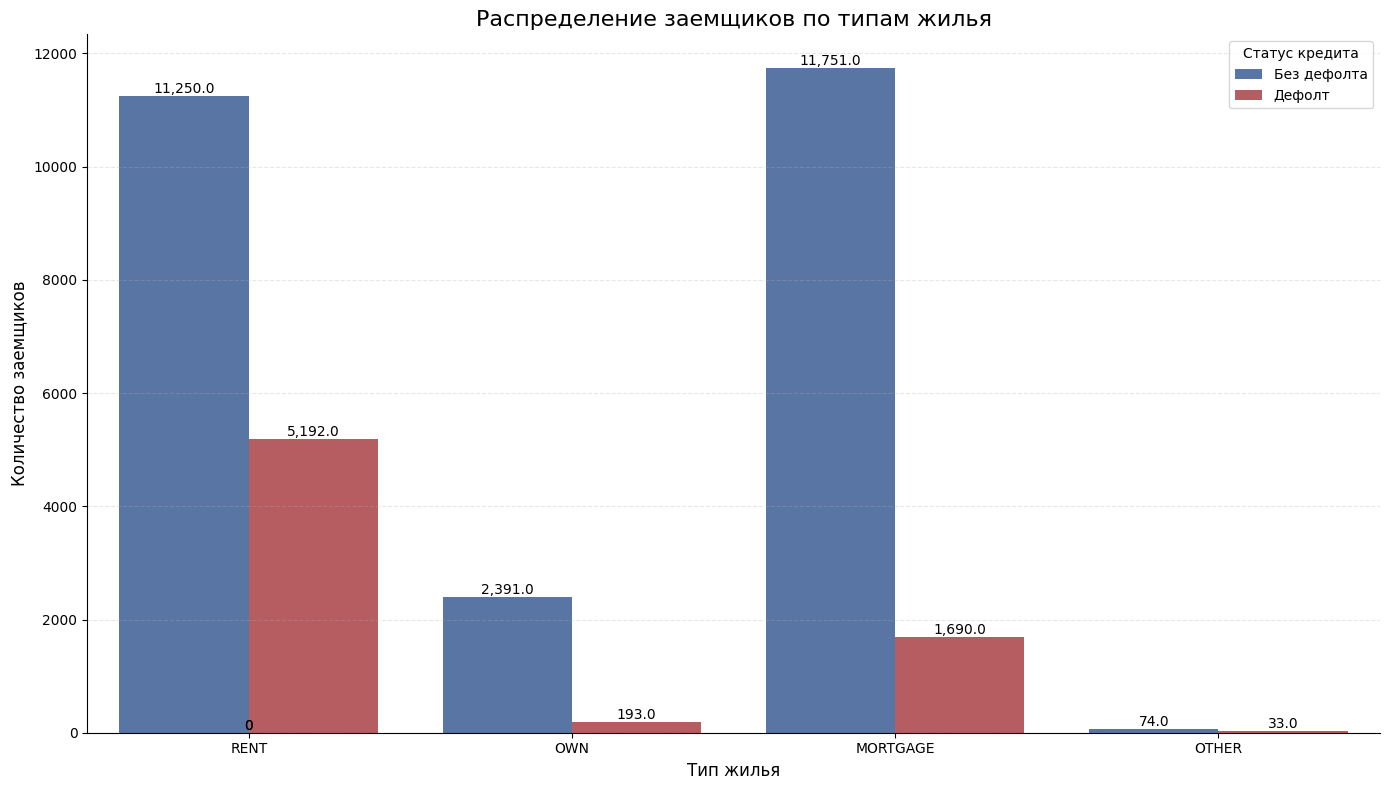


Всего клиентов: 32,574

Тип жилья: RENT
Количество: 16,442 (50.5% от всех)
Дефолтов: 5,192 (31.6%)

Тип жилья: OWN
Количество: 2,584 (7.9% от всех)
Дефолтов: 193 (7.5%)

Тип жилья: MORTGAGE
Количество: 13,441 (41.3% от всех)
Дефолтов: 1,690 (12.6%)

Тип жилья: OTHER
Количество: 107 (0.3% от всех)
Дефолтов: 33 (30.8%)


In [21]:
plt.figure(figsize=(14, 8))

ax = sns.countplot(x='person_home_ownership', 
                  hue='loan_status',
                  data=df,
                  palette=['#4c72b0', '#c44e52'])

plt.title('Распределение заемщиков по типам жилья', fontsize=16)
plt.xlabel('Тип жилья', fontsize=12)
plt.ylabel('Количество заемщиков', fontsize=12)
plt.legend(title='Статус кредита', labels=['Без дефолта', 'Дефолт'], frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=10)

sns.despine()
plt.tight_layout()
plt.show()

total_clients = len(df)
print(f"\nВсего клиентов: {total_clients:,}")
for housing_type in df['person_home_ownership'].unique():
    group = df[df['person_home_ownership'] == housing_type]
    default_count = group['loan_status'].sum()
    print(f"\nТип жилья: {housing_type}")
    print(f"Количество: {len(group):,} ({len(group)/total_clients*100:.1f}% от всех)")
    print(f"Дефолтов: {default_count:,} ({group['loan_status'].mean()*100:.1f}%)")

#### `Большинство людей, берущих кредит, не имеет собственного жилья. Доля клиентов, имеющих какое-либо владение, составляет всего 7.9%`

#### `Помимо этого, можно сделать следующий вывод: арендаторы жилья (RENT) представляют собой наиболее проблемную категорию заёмщиков. Эта группа не только является самой многочисленной (50.5% от общего числа клиентов), но и демонстрирует наибольший уровень дефолтов - 31.6%. Фактически каждый третий арендатор не исполняет свои кредитные обязательства.`

#### `В отличие от них, клиенты с ипотекой (MORTGAGE) и владельцы собственного жилья (OWN) показывают значительно лучшую платёжную дисциплину. Ипотечники, составляя 41.3% клиентской базы, демонстрируют уровень дефолтов всего 12.6%, что гораздо ниже показателя для арендаторов. Владельцы жилья, хотя и менее многочисленные (7.9% клиентов), также проявляют большую ответственность при погашении кредитов (7.5% дефолтов).`

# Доход клиентов

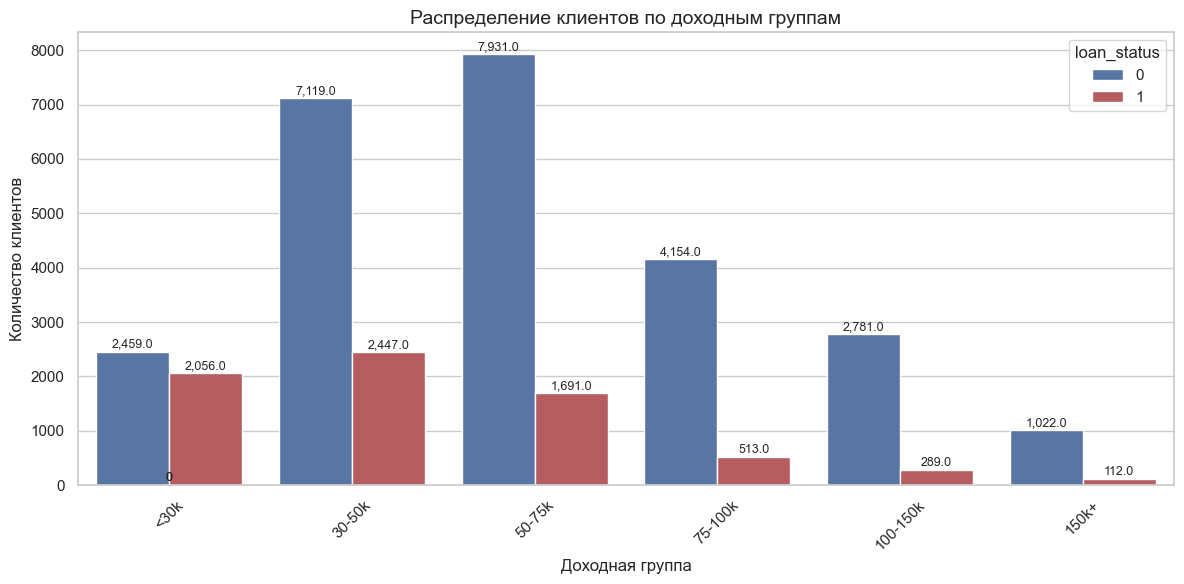

Всего клиентов: 32,574

Доходная группа: <30k
Количество: 4,515.0 (13.9% от всех)
Дефолтов: 2,056.0 (45.5%)
Без дефолтов: 2,459.0

Доходная группа: 30-50k
Количество: 9,566.0 (29.4% от всех)
Дефолтов: 2,447.0 (25.6%)
Без дефолтов: 7,119.0

Доходная группа: 50-75k
Количество: 9,622.0 (29.5% от всех)
Дефолтов: 1,691.0 (17.6%)
Без дефолтов: 7,931.0

Доходная группа: 75-100k
Количество: 4,667.0 (14.3% от всех)
Дефолтов: 513.0 (11.0%)
Без дефолтов: 4,154.0

Доходная группа: 100-150k
Количество: 3,070.0 (9.4% от всех)
Дефолтов: 289.0 (9.4%)
Без дефолтов: 2,781.0

Доходная группа: 150k+
Количество: 1,134.0 (3.5% от всех)
Дефолтов: 112.0 (9.9%)
Без дефолтов: 1,022.0



In [22]:
income_bins = [0, 30000, 50000, 75000, 100000, 150000, float('inf')]
income_labels = ['<30k', '30-50k', '50-75k', '75-100k', '100-150k', '150k+']
df['income_group'] = pd.cut(df['person_income'], bins=income_bins, labels=income_labels)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

ax = sns.countplot(x='income_group', 
                  hue='loan_status',
                  data=df,
                  palette={0: '#4c72b0', 1: '#c44e52'})  # 0 - без дефолта, 1 - дефолт

for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=9)

plt.title('Распределение клиентов по доходным группам', fontsize=14)
plt.xlabel('Доходная группа', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.legend(title='loan_status', labels=['0', '1'])
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
income_stats = df.groupby('income_group', observed=True).agg(
    clients=('loan_status', 'count'),
    defaults=('loan_status', 'sum')
).assign(
    percent_total=lambda x: (x['clients'] / total_clients * 100).round(1),
    default_rate=lambda x: (x['defaults'] / x['clients'] * 100).round(1),
    no_defaults=lambda x: x['clients'] - x['defaults']
)
print(f"Всего клиентов: {total_clients:,}\n")

for group in income_stats.index:
    stats = income_stats.loc[group]
    print(f"Доходная группа: {group}")
    print(f"Количество: {stats['clients']:,} ({stats['percent_total']}% от всех)")
    print(f"Дефолтов: {stats['defaults']:,} ({stats['default_rate']}%)")
    print(f"Без дефолтов: {stats['no_defaults']:,}\n")

#### `Прослежиается четкая зависимость между уровнем дохода и вероятностью дефолта. Анализ показывает, что наиболее рискованной категорией являются заемщики с годовым доходом ниже $30,000. В этой группе, составляющей 13.9% от общего числа клиентов, уровень дефолтов - 45.5%.`

#### `С увеличением дохода наблюдается устойчивое снижение кредитных рисков. В группе $30,000-$50,000 (29.4% клиентов) дефолты сокращаются до 25.6%, а при доходе $50,000-$75,000 (29.5% клиентской базы) - до 17.6%. В категории $75,000-$100,000 уровень дефолтов составляет 11.0%, что в 4 раза меньше, чем у наименее обеспеченных заемщиков.`

#### `Наиболее надежными оказались клиенты с доходом свыше $100,000. В этих группах (вместе составляющих около 13% от общего числа) уровень дефолтов стабильно держится ниже 10%.`

# 2. Обучение модели

## CatBoost

In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [24]:
df_СatBoost = pd.read_csv('credit_risk_dataset.csv')

In [25]:
df_СatBoost.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [26]:
df_СatBoost.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [27]:
result = df_СatBoost.iloc[:, 8]
result

0        1
1        0
2        1
3        1
4        1
        ..
32576    0
32577    0
32578    1
32579    0
32580    0
Name: loan_status, Length: 32581, dtype: int64

In [28]:
predictions_cat =  df_СatBoost.drop(columns=['loan_status'])
predictions_cat

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26


In [29]:
x_train, x_test, y_train, y_test = train_test_split(predictions_cat, result, test_size = 0.3, random_state = 0)

In [30]:
categorics = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

In [31]:
catboost = CatBoostClassifier(task_type='CPU', iterations=140, learning_rate=0.1, depth = 5, random_state = 5, 
                              eval_metric="Accuracy")

In [32]:
catboost.fit( x_train, y_train, cat_features= categorics, plot=True, eval_set=(x_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8340788	test: 0.8395908	best: 0.8395908 (0)	total: 174ms	remaining: 24.2s
1:	learn: 0.8365781	test: 0.8424552	best: 0.8424552 (1)	total: 196ms	remaining: 13.5s
2:	learn: 0.8506533	test: 0.8557545	best: 0.8557545 (2)	total: 223ms	remaining: 10.2s
3:	learn: 0.8526703	test: 0.8572890	best: 0.8572890 (3)	total: 247ms	remaining: 8.4s
4:	learn: 0.8538542	test: 0.8579028	best: 0.8579028 (4)	total: 274ms	remaining: 7.4s
5:	learn: 0.8509164	test: 0.8559591	best: 0.8579028 (4)	total: 301ms	remaining: 6.72s
6:	learn: 0.8505656	test: 0.8553453	best: 0.8579028 (4)	total: 326ms	remaining: 6.2s
7:	learn: 0.8507849	test: 0.8554476	best: 0.8579028 (4)	total: 353ms	remaining: 5.82s
8:	learn: 0.8549066	test: 0.8582097	best: 0.8582097 (8)	total: 393ms	remaining: 5.72s
9:	learn: 0.8620538	test: 0.8656777	best: 0.8656777 (9)	total: 424ms	remaining: 5.5s
10:	learn: 0.8746821	test: 0.8785678	best: 0.8785678 (10)	total: 448ms	remaining: 5.26s
11:	learn: 0.8786723	test: 0.8839898	best: 0.8839898 (11

In [33]:
accuracy = catboost.score(x_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9341176470588235



Точность модели (Accuracy): 0.9341176470588235

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7744
           1       0.95      0.72      0.82      2031

    accuracy                           0.93      9775
   macro avg       0.94      0.85      0.89      9775
weighted avg       0.94      0.93      0.93      9775



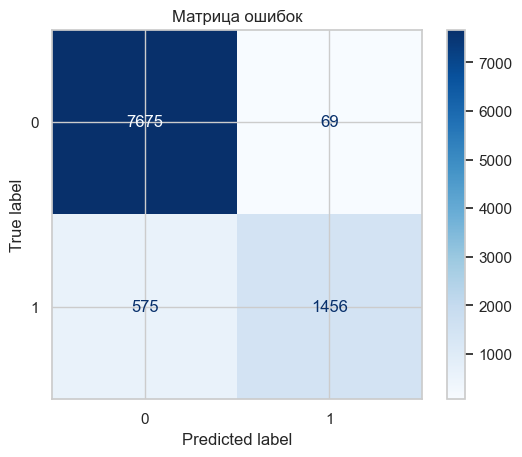


Топ-5 важных признаков:


,Признак,Важность
8,loan_percent_income,24.771010
2,person_home_ownership,19.744467
5,loan_grade,14.547528
1,person_income,14.160225
4,loan_intent,11.184322


In [34]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = catboost.predict(x_test)
print("\nТочность модели (Accuracy):", accuracy_score(y_test, y_pred))
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Матрица ошибок')
plt.show()

feature_importance = pd.DataFrame({'Признак': x_train.columns,'Важность': 
                                   catboost.feature_importances_}).sort_values('Важность', ascending=False).head(5)

print("\nТоп-5 важных признаков:")
display(feature_importance)